# Creating a model that detects spam emails and a POS tagger using the RNN arhitecture.

# Model that detects spam emails

There will be 2 arhitectures, the LSTM and GRU one. The dataset consists of 5572 rows of emails, where X is the email text and Y is the label. The label have 2 values: spam, meaning the email is classified as spam and ham, meaning the email is not classified as spam. The dataset is provided on github.

In [19]:
!pip install Keras-Preprocessing
import pandas as pd
import re
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, GRU, SimpleRNN
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from matplotlib import pyplot as plt
from keras.layers import TimeDistributed
from keras.utils import to_categorical




In [4]:
data = pd.read_csv("spam.csv", encoding='ISO-8859-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
print(f"The number of rows are: {data.shape[0]}")
x = data.v2
y = data.v1

The number of rows are: 5572


## Data Preprocessing

Making the text lowercase -> reducing the complexity of the model

In [6]:
def to_lower(value):
  x_lower = value.map(lambda x: x.lower())
  return x_lower

In [7]:
#making a copy of the column x, so we do not make changes to the actual data
x_copy = x.copy()
x_copy = to_lower(x_copy)

In [8]:
x_copy.head()

0    go until jurong point, crazy.. available only ...
1                        ok lar... joking wif u oni...
2    free entry in 2 a wkly comp to win fa cup fina...
3    u dun say so early hor... u c already then say...
4    nah i don't think he goes to usf, he lives aro...
Name: v2, dtype: object

Removal of special characters, numbers. For this everything that is not in the pattern is removed.

In [9]:
def clean_text(value):
  #only small letters and big letters are kept
  pattern = '[^a-zA-Z\s]'
  processed_data = []
  for i in value:
    new_value = re.sub(pattern, '', i)
    processed_data.append(new_value)
  return processed_data

In [72]:
x_copy = clean_text(x_copy)
print(x_copy[0])

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat


Processing the label y. We encode spam as 1 and ham as 0.

In [73]:
counter = 0
arr = []
for label in y:
    if label == 'spam':
        counter += 1
        arr.append(1)
    else:
        arr.append(0)

y_copy = arr
# Convert y to a numpy array and reshape it
y_copy = np.array(y_copy).reshape(-1, 1)

y_copy #(ne, 1)


array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [74]:
print(f"There are {counter} spam emails and {data.shape[0] - counter} not spam emails")

There are 747 spam emails and 4825 not spam emails


## Tokenization using Keras Tokenizer class.
Every unique word is encoded as an unique integer. No two different words can have the same integer. In this way we keep track of the words order, which makes the model more accurately classify the emails.

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_copy)
#converts text to sequence of integers
x_encoded = tokenizer.texts_to_sequences(x_copy)
vocab_word_to_index = tokenizer.word_index

In [13]:
print(x_copy[25])
print(x_encoded[25])

just forced myself to eat a slice im really not hungry tho this sucks mark is getting worried he knows im sick when i turn down pizza lol
[36, 3982, 934, 1, 310, 4, 2715, 22, 146, 24, 735, 633, 39, 1218, 1107, 9, 242, 1015, 70, 935, 22, 1016, 43, 2, 1766, 223, 1108, 175]


## Padding using pad_sequences() from Keras

When we pad the sequences we want to know how many times to unroll the network. For this we get the lengths of all documents and choose the biggest one for maxlen.

In [14]:
def lenghts(X):
    arr = []
  #loop through each row
    for i in X:
        arr.append(len(i))
    return arr


length = max(lenghts(x_encoded))
print(f'The length of the largest document is {length}')

The length of the largest document is 171


We proceed to pad the sequences using Keras pad_sequences(). Sentences longer than maxlen will be truncated, sentences shorter than maxlen will be padded with 0. The padding is done before the sentence and the trucating after the sentence.
vocab_size is the size of the vocabulary, the number of unique integers of the tokenized data. Since the Keras Tokenizer starts numbering tokens from 1, searching for the largest integer in the x_padded 2D array is our approach. At the end we add 1 to the vocab_size to account for padding.

In [15]:
x_padded = pad_sequences(x_encoded, maxlen= length, padding='pre', truncating='post')
vocab_size = np.max(np.array(x_padded)) + 1
print(f'The size of vocab is {vocab_size}')

The size of vocab is 8541


In [16]:
print(x_copy[10])
print(x_encoded[10])
print(x_padded[10])

im gonna be home soon and i dont want to talk about this stuff anymore tonight k ive cried enough today
[22, 218, 31, 78, 208, 7, 2, 42, 67, 1, 263, 75, 39, 277, 1104, 209, 151, 168, 3968, 411, 89]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   22  218   31   78
  208    7    2   42 

## Splitting the data into train and test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(x_padded, y_copy, test_size=0.25, random_state=100)

## Implemenation
We start with the LSTM a special arhitecure of RNN, which is intended to better capture long-term dependencies compared to traditional RNNs. They are capable of learning long-term dependencies in sequence data.
The integers are mapped to denes vectors of size 64, being the dimension of the embeddings. A LSTM layer of 32 neurons is added and the activation function is sigmoid, as binary classification is performed.


In [23]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length= length))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 171, 64)           546624    
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 559073 (2.13 MB)
Trainable params: 559073 (2.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [25]:
#training the model for 80 epochs, which is appropriate given the batch_size and iterable data size
model.fit(X_train, y_train, epochs=80, validation_data=(X_test, y_test), batch_size= 45)

Epoch 1/80
93/93 [==============================] - 8s 66ms/step - loss: 0.2973 - accuracy: 0.9048 - val_loss: 0.0887 - val_accuracy: 0.9799
Epoch 2/80
93/93 [==============================] - 5s 55ms/step - loss: 0.0610 - accuracy: 0.9842 - val_loss: 0.0546 - val_accuracy: 0.9871
Epoch 3/80
93/93 [==============================] - 6s 60ms/step - loss: 0.0229 - accuracy: 0.9950 - val_loss: 0.0489 - val_accuracy: 0.9864
Epoch 4/80
93/93 [==============================] - 5s 58ms/step - loss: 0.0134 - accuracy: 0.9974 - val_loss: 0.0455 - val_accuracy: 0.9899
Epoch 5/80
93/93 [==============================] - 6s 65ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 0.0509 - val_accuracy: 0.9892
Epoch 6/80
93/93 [==============================] - 6s 66ms/step - loss: 0.0044 - accuracy: 0.9990 - val_loss: 0.0567 - val_accuracy: 0.9878
Epoch 7/80
93/93 [==============================] - 6s 61ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.0892 - val_accuracy: 0.9742
Epoch 8/80
93

As you can see the model attained a high accuracy on testing data, 98.64% accuracy.

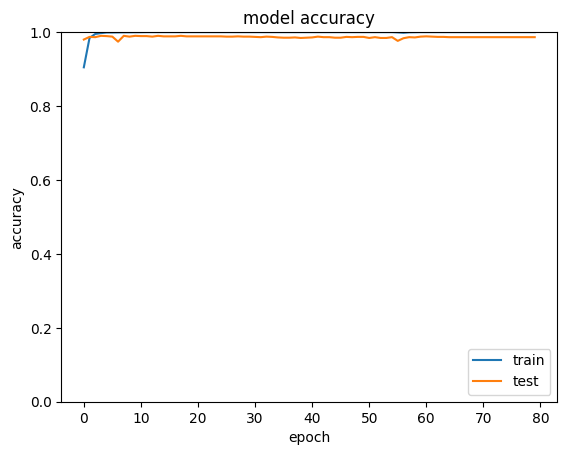

In [27]:
# visualise training history
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc="lower right")
plt.show()

We then proceed to implement a GRU model, which is desinged for capturing long-term dependencies in sequence data like LSTM, but they do so with a simpler structural design. GRU does not have a separate cell state. It combines the cell state and the hidden state, simplifying the model and reducing the number of parameters.

In [32]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=length))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))
# model summary
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 171, 64)           546624    
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 556065 (2.12 MB)
Trainable params: 556065 (2.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
model.fit(X_train, y_train, epochs=80, validation_data=(X_test, y_test), batch_size=45)

Epoch 1/80
93/93 [==============================] - 8s 64ms/step - loss: 0.3336 - accuracy: 0.8837 - val_loss: 0.0938 - val_accuracy: 0.9734
Epoch 2/80
93/93 [==============================] - 6s 64ms/step - loss: 0.0566 - accuracy: 0.9847 - val_loss: 0.0530 - val_accuracy: 0.9871
Epoch 3/80
93/93 [==============================] - 7s 77ms/step - loss: 0.0218 - accuracy: 0.9955 - val_loss: 0.0504 - val_accuracy: 0.9892
Epoch 4/80
93/93 [==============================] - 6s 60ms/step - loss: 0.0106 - accuracy: 0.9974 - val_loss: 0.0483 - val_accuracy: 0.9878
Epoch 5/80
93/93 [==============================] - 7s 73ms/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 0.0496 - val_accuracy: 0.9885
Epoch 6/80
93/93 [==============================] - 6s 69ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.0525 - val_accuracy: 0.9871
Epoch 7/80
93/93 [==============================] - 6s 61ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0621 - val_accuracy: 0.9864
Epoch 8/80
93

The LSTM arhitecture performed slightly better than the GRU by 0.0029.

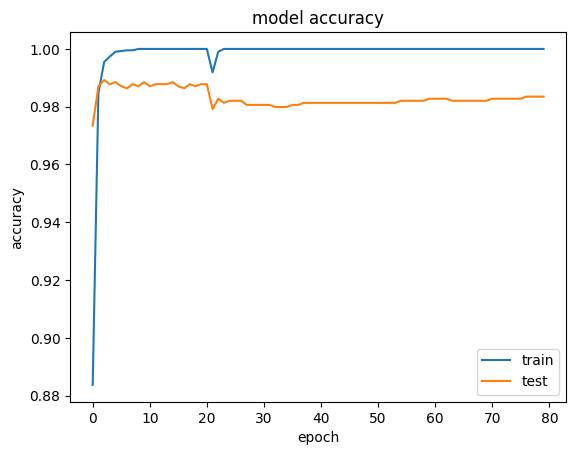

In [35]:
# visualise training history
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

Trying to improve it father by creating a model using pre-trained embeddings, which can lead to better performance as it is trained on large text using Google News, where embedding size is 300.

### Because of the large size the file is uploaded to google drive.

```
# This is formatted as code
```



In [37]:
from google.colab import drive
import os
from gensim.models import KeyedVectors

drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/Embeddings'
filename = 'GoogleNews-vectors-negative300.bin'


path = os.path.join(folder_path, filename)

word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

Mounted at /content/drive


In [38]:
embedding_size = 300
embeddings = np.zeros((vocab_size, embedding_size))

#one row corresponds to the embeddings of one word in the vocabulary
for i, j in vocab_word_to_index.items():
  if i in word2vec:
    embeddings[j] = word2vec[i]

print(embeddings.shape)

(8541, 300)


In [40]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[embeddings], input_length=length, trainable=False))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 171, 300)          2562300   
                                                                 
 lstm_2 (LSTM)               (None, 32)                42624     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2604957 (9.94 MB)
Trainable params: 42657 (166.63 KB)
Non-trainable params: 2562300 (9.77 MB)
_________________________________________________________________


In [41]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
model.fit(X_train, y_train, epochs=80, validation_data=(X_test, y_test), batch_size = 45)

Epoch 1/80
93/93 [==============================] - 10s 94ms/step - loss: 0.2482 - accuracy: 0.9038 - val_loss: 0.1054 - val_accuracy: 0.9634
Epoch 2/80
93/93 [==============================] - 8s 83ms/step - loss: 0.0870 - accuracy: 0.9710 - val_loss: 0.0860 - val_accuracy: 0.9727
Epoch 3/80
93/93 [==============================] - 8s 90ms/step - loss: 0.0690 - accuracy: 0.9792 - val_loss: 0.0731 - val_accuracy: 0.9734
Epoch 4/80
93/93 [==============================] - 8s 90ms/step - loss: 0.0569 - accuracy: 0.9818 - val_loss: 0.0648 - val_accuracy: 0.9792
Epoch 5/80
93/93 [==============================] - 8s 88ms/step - loss: 0.0409 - accuracy: 0.9890 - val_loss: 0.0654 - val_accuracy: 0.9785
Epoch 6/80
93/93 [==============================] - 8s 90ms/step - loss: 0.0357 - accuracy: 0.9904 - val_loss: 0.0635 - val_accuracy: 0.9777
Epoch 7/80
93/93 [==============================] - 8s 91ms/step - loss: 0.0415 - accuracy: 0.9876 - val_loss: 0.0640 - val_accuracy: 0.9813
Epoch 8/80
9

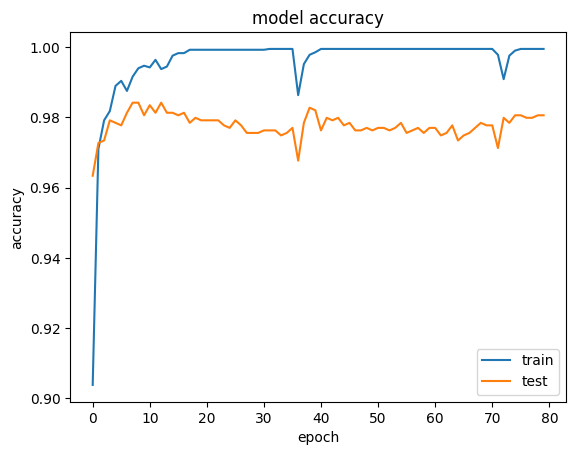

In [43]:
# visualise training history
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

# Lets try a multi classification problem and build our POS tagger

The POS tagger helps us understand the syntatic structure of the sentence. We build a statistical model to learn a POS tagger, using the TreeBank dataset

In [11]:
import nltk
from nltk.corpus import treebank

nltk.download('treebank')
nltk.download('universal_tagset')

corpus = treebank.tagged_sents(tagset='universal')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [12]:
print(corpus[0])

[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]


In [13]:
X = []
Y = []

# loop through the rows in corpus
for row in range(0, len(corpus)):
    X_row = []
    y_row = []
    for val in range(0, len(corpus[row])):
        one = corpus[row][val]
        X_row.append(one[0])
        y_row.append(one[1])
    X.append(X_row)
    Y.append(y_row)


In [14]:
print(X[1])
print(Y[1])

['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.']
['NOUN', 'NOUN', 'VERB', 'NOUN', 'ADP', 'NOUN', 'NOUN', '.', 'DET', 'NOUN', 'VERB', 'NOUN', '.']


Convert X and Y to integers using Keras Tokenizer

In [15]:
tokenizer1 = Tokenizer()
tokenizer2 = Tokenizer()
tokenizer1.fit_on_texts(X)
tokenizer2.fit_on_texts(Y)
X_encoded = tokenizer1.texts_to_sequences(X)
Y_encoded = tokenizer2.texts_to_sequences(Y)

In [30]:
vocab_word_to_index = tokenizer1.word_index
class_tokenizer = tokenizer2.word_index

We get the vocabulary size for X (number of unique integers) and the number of classes for Y (will be the classes that the model need to classify).

In [16]:
def getValues(data):
    maximum = 0
    for i in range(0, len(data)):
        if max(data[i]) > maximum:
            maximum = max(data[i])
    return maximum


size_vocab = getValues(X_encoded) + 1 #add 1 because of the padding 0
pos = getValues(Y_encoded)



print(f'The size of vocab is {size_vocab}')
print(f'The size of pos tags is {pos}')




The size of vocab is 11388
The size of pos tags is 12


We get the lengths of the arrays we will pad as the length of the biggest sentence. This will be the value for maxlen.

In [17]:
def lenghts(X):
    arr = []
    for i in X:
        arr.append(len(i))
    return arr

length1 = max(lenghts(X_encoded))
length2 = max(lenghts(Y_encoded))
X_padded = pad_sequences(X_encoded, maxlen= length1, padding='pre')
Y_padded = pad_sequences(Y_encoded, maxlen= length2, padding='pre')


In [18]:
print(X_padded[1])
print(Y_padded[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

We hot encode the values of Y_padded

In [20]:
Y = to_categorical(Y_padded)
pos = Y.shape[2]

Split the data into train and test

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, Y, test_size=0.25, random_state=100)

We will do the POS tagger by creating a model using pre-trained embeddings, which can lead to better performance as it is trained on large text using Google News, where embedding size is 300.

### Because of the large size the file is uploaded to google drive.


In [22]:
from google.colab import drive
import os
from gensim.models import KeyedVectors

drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/Embeddings'
filename = 'GoogleNews-vectors-negative300.bin'


path = os.path.join(folder_path, filename)

word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

Mounted at /content/drive


In [26]:
embedding_size = 300
embeddings = np.zeros((size_vocab, embedding_size))

#one row corresponds to the embeddings of one word in the vocabulary
for i, j in vocab_word_to_index.items():
  if i in word2vec:
    embeddings[j] = word2vec[i]

print(embeddings.shape)

(11388, 300)


Creating the model using the LSTM arhitecture

In [27]:
model2 = Sequential()
model2.add(Embedding(input_dim=size_vocab, output_dim=embedding_size, weights=[embeddings], input_length=length1, trainable=False))
model2.add(LSTM(32, return_sequences=True))
model2.add(TimeDistributed(Dense(pos, activation='softmax')))
# model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 271, 300)          3416400   
                                                                 
 lstm (LSTM)                 (None, 271, 32)           42624     
                                                                 
 time_distributed (TimeDist  (None, 271, 13)           429       
 ributed)                                                        
                                                                 
Total params: 3459453 (13.20 MB)
Trainable params: 43053 (168.18 KB)
Non-trainable params: 3416400 (13.03 MB)
_________________________________________________________________


In [28]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model2.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
92/92 [==============================] - 21s 195ms/step - loss: 1.0026 - accuracy: 0.9205 - val_loss: 0.3242 - val_accuracy: 0.9282
Epoch 2/40
92/92 [==============================] - 18s 200ms/step - loss: 0.2919 - accuracy: 0.9312 - val_loss: 0.2610 - val_accuracy: 0.9348
Epoch 3/40
92/92 [==============================] - 17s 188ms/step - loss: 0.2447 - accuracy: 0.9385 - val_loss: 0.2241 - val_accuracy: 0.9460
Epoch 4/40
92/92 [==============================] - 19s 206ms/step - loss: 0.2123 - accuracy: 0.9494 - val_loss: 0.1955 - val_accuracy: 0.9530
Epoch 5/40
92/92 [==============================] - 19s 212ms/step - loss: 0.1856 - accuracy: 0.9548 - val_loss: 0.1711 - val_accuracy: 0.9591
Epoch 6/40
92/92 [==============================] - 19s 207ms/step - loss: 0.1631 - accuracy: 0.9622 - val_loss: 0.1510 - val_accuracy: 0.9657
Epoch 7/40
92/92 [==============================] - 20s 216ms/step - loss: 0.1448 - accuracy: 0.9662 - val_loss: 0.1351 - val_accuracy: 0.9681

## Testing the model

In [37]:
text=['Pertaining to this context, Sentiment Analysis represents an area of study that leverages natural language processing to interpret and classify emotions in textual data, thereby transforming unstructured text into meaningful insights, tailored to fulfill the specific understanding requirements of the audience.',
      'In this vein, Machine Translation stands as a pivotal field in computational linguistics, focusing on the use of algorithms to convert text or speech from one language to another, effectively narrowing the communication divide by transforming multilingual data into accessible and actionable information, customized for diverse linguistic needs.']

We need to process the text the same way as the text the model was trained on, so we tokenize it.



In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
X_encoded = tokenizer.texts_to_sequences(text)

In [39]:
X_padded = pad_sequences(X_encoded, maxlen=length1, padding='pre', truncating='post')


We get the labels Y and create a dictionary with them, where the key is the class and the value is what it maps to.

In [40]:
predictions = model2.predict(X_padded)

map_tokens = class_tokenizer
dicti = {v: k for k, v in map_tokens.items()}

print(dicti)


1/1 [==============================] - 0s 44ms/step
{1: 'noun', 2: 'verb', 3: '.', 4: 'adp', 5: 'det', 6: 'x', 7: 'adj', 8: 'num', 9: 'prt', 10: 'adv', 11: 'pron', 12: 'conj'}


In [43]:

predicted_arr = []


prediction = np.argmax(predictions, axis=2)
#loop through rows
for row in range(0,len(prediction)):
    arr = []
    for word in range(0, len(prediction[row])):
        pr = prediction[row][word]
        if pr in dicti:
            arr.append(dicti.get(pr))
    if len(arr) > 0:
        predicted_arr.append(arr)

str_arr = []
for sentence in text:
    tokens = re.split(r'([.])|\s+', sentence)
    tokens = list(filter(None, tokens))
    str_arr.append(tokens)



final_val = []
#loop through rows of predicted
for i in range(0, len(predicted_arr)):
    for m in range(0, len(str_arr)):
        #if the rows are the same
        if i == m:
            arr = []
          #looping through the numbers of the prediction
            for j in range(0, len(predicted_arr[i])):
                tuple1 = (str_arr[m][j], predicted_arr[i][j])
                arr.append(tuple1)
    final_val.append(arr)

print(final_val[0])
print(final_val[1])


[('Pertaining', 'adp'), ('to', 'det'), ('this', 'x'), ('context,', '.'), ('Sentiment', '.'), ('Analysis', 'num'), ('represents', 'x'), ('an', '.'), ('area', 'verb'), ('of', 'verb'), ('study', 'pron'), ('that', 'x'), ('leverages', 'adp'), ('natural', 'det'), ('language', 'noun'), ('processing', 'adp'), ('to', 'adp'), ('interpret', 'adp'), ('and', 'noun'), ('classify', 'adp'), ('emotions', 'det'), ('in', 'adp'), ('textual', 'det'), ('data,', 'adp'), ('thereby', 'x'), ('transforming', 'x'), ('unstructured', 'num'), ('text', 'x'), ('into', '.'), ('meaningful', '.'), ('insights,', 'verb'), ('tailored', 'det'), ('to', 'verb'), ('fulfill', 'verb'), ('the', 'det'), ('specific', '.'), ('understanding', 'det'), ('requirements', 'pron')]
[('In', 'verb'), ('this', 'det'), ('vein,', 'adj'), ('Machine', 'verb'), ('Translation', 'adv'), ('stands', 'conj'), ('as', 'pron'), ('a', 'conj'), ('pivotal', '.'), ('field', 'verb'), ('in', 'pron'), ('computational', 'noun'), ('linguistics,', '.'), ('focusing',

As you can see the model does not perform so well on unseen data, even though the testing accuracy is 98.38%, the explanation is that the model has not been trained on a large amount of data.